In [12]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datetime import datetime 
from pathlib import Path

import plotly.express as px
import my_utilities
import custom_functions as cf

cfg = my_utilities.__cfg_reading()

KPI_LIST = ['adCost','clicksCounter','impressionsCounter']
PROJECT_PATH = eval(cfg['PROJECT_PATH'])
DATA_PATH = PROJECT_PATH/cfg['DATA_FOLDER']
FILE = cfg['FILE_TO_EXPLORE']
OUTPUT_FILE = cfg['OUTPUT_FILE']

In [13]:
df = pd.read_csv(DATA_PATH/FILE)
df.sort_values(by='calDate', inplace=True, ignore_index=True)
df['calDate'] = pd.to_datetime(df['calDate']).dt.date
print(f"# records: {len(df)}")


# records: 1311


Ci sono duplicati?

In [14]:
assert len(df) == len(df.drop_duplicates()), "KO"

# DATASET

Distribuzioni

1th percentile for column adCost is 0.0
25th percentile for column adCost is 4.835
50th percentile for column adCost is 7.06
75.9th percentile for column adCost is 12.6487
99th percentile for column adCost is 56.99500000000015
Avg value for column adCost is 10.652934575133477
1th percentile for column clicksCounter is 0.0
25th percentile for column clicksCounter is 14.0
50th percentile for column clicksCounter is 25.0
75.9th percentile for column clicksCounter is 36.0
99th percentile for column clicksCounter is 157.70000000000027
Avg value for column clicksCounter is 30.142639206712435
1th percentile for column impressionsCounter is 0.0
25th percentile for column impressionsCounter is 84.0
50th percentile for column impressionsCounter is 177.0
75.9th percentile for column impressionsCounter is 1195.29
99th percentile for column impressionsCounter is 12604.500000000013
Avg value for column impressionsCounter is 1438.2028985507247


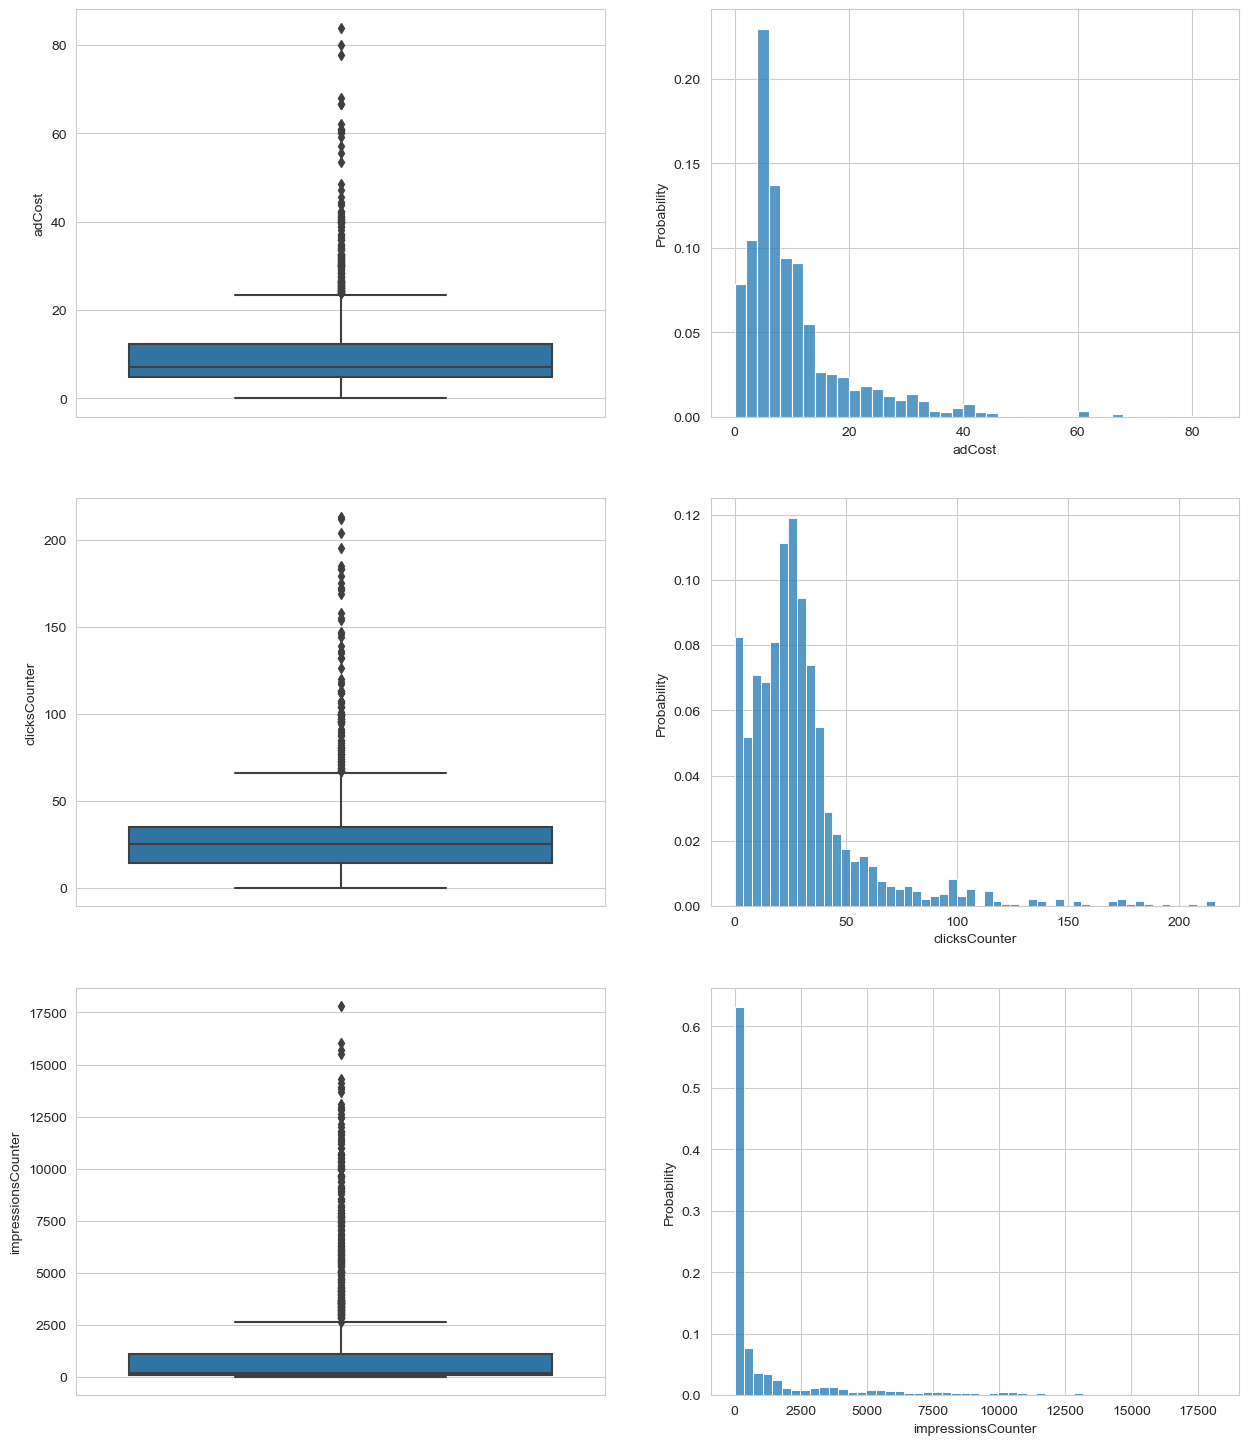

In [15]:
import numpy
columns = KPI_LIST
percentile_list = [1,25,50,75.90,99]

cf.print_box_histplot(df, columns, percentile_list)

Ci sono dei connectionStream che hanno sempre costo zero?

In [16]:
cstream_nocost = cf.not_common_elements(df['connectionStream'], df[df['adCost']!=0]['connectionStream'])
cstream_nocost

[]

Vediamo se ha senso tenerli. Guardo se hanno dei click o delle impression

In [47]:
cstram_droppable = cf.elements_droppable(df, cstream_nocost, which_el='campaignId', kpis = ['clicksCounter','impressionsCounter'])
cstram_droppable

[]

Posso quindi droppare i 2 connectionStream

In [48]:
df = df[~df['connectionStream'].isin(cstram_droppable)].reset_index(drop=True)

Alla stessa maniera provo a vedere se ci sono delle campagne che posso rimuovere

In [49]:
kpis = ['clicksCounter','impressionsCounter']
campaign_nocost = cf.not_common_elements(df['campaignId'], df[df['adCost']!=0]['campaignId'])
campaign_to_drop = cf.elements_droppable(df, campaign_nocost, which_el='campaignId', kpis = ['clicksCounter','impressionsCounter'])

print(len(campaign_nocost) - len(campaign_to_drop))

0


Scopro che le 13 campagne sopra, sono campagne a cui non è stato erogato alcun costo, che hanno 0 click ma hanno delle impression !=0. 


Nel link: https://sell.amazon.it/pubblicita scopro che le impression non si pagano: 


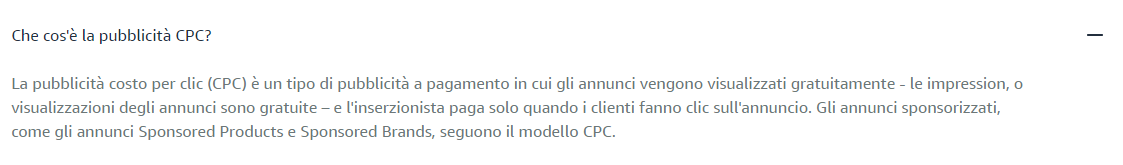 


Pertanto decido di droppare solo quelle che hanno anche impression a 0

In [50]:
df = df[~df['campaignId'].isin(campaign_to_drop)].reset_index(drop=True)
df.head(5)

,calDate,connectionStream,adCost,campaignId,clicksCounter,impressionsCounter
0,2021-08-02,4580834090943463925.google_ads,11.40,6045900822755737895,7.0,89.0
1,2021-08-02,4580834090943463925.google_ads,6.61,1886376307672751723,6.0,25.0
2,2021-08-02,4580834090943463925.google_ads,0.00,3569910158619531168,0.0,2.0
3,2021-08-02,4580834090943463925.google_ads,10.44,-8587735845139407532,10.0,68.0
4,2021-08-03,4580834090943463925.google_ads,12.09,6045900822755737895,10.0,104.0


Ovviamente ne tovo ancora (Es.280346389415384) perchè devo andare a vedere riga per riga.

Il che dovrebbe essere equivalente a dire che droppo tutte le righe il cui impressionCounter = 0.


In [51]:
df = df[df['impressionsCounter']!=0].reset_index(drop=True)
df.head(5)

,calDate,connectionStream,adCost,campaignId,clicksCounter,impressionsCounter
0,2021-08-02,4580834090943463925.google_ads,11.40,6045900822755737895,7.0,89.0
1,2021-08-02,4580834090943463925.google_ads,6.61,1886376307672751723,6.0,25.0
2,2021-08-02,4580834090943463925.google_ads,0.00,3569910158619531168,0.0,2.0
3,2021-08-02,4580834090943463925.google_ads,10.44,-8587735845139407532,10.0,68.0
4,2021-08-03,4580834090943463925.google_ads,12.09,6045900822755737895,10.0,104.0


Adesso guardo se a parità di calDate, campaignId ci sono più valori

In [52]:
df.groupby(['calDate', 'campaignId'])['connectionStream'].agg(['count','nunique']).reset_index().sort_values(['count'], ascending=False).head(5)

,calDate,campaignId,count,nunique
0,2021-08-02,-8587735845139407532,1,1
831,2022-03-14,1886376307672751723,1,1
838,2022-03-21,1886376307672751723,1,1
837,2022-03-20,1886376307672751723,1,1
836,2022-03-19,1886376307672751723,1,1


Ci sono più record a parità di coppia calDate, campaignId, sommo i costi ed i relativi KPI

In [53]:
df = df.groupby(['calDate', 'connectionStream', 'campaignId'])['adCost','clicksCounter','impressionsCounter'].sum().reset_index()
df.tail(5)

,calDate,connectionStream,campaignId,adCost,clicksCounter,impressionsCounter
1246,2023-02-10,4580834090943463925.google_ads,1886376307672751723,8.06,22.0,92.0
1247,2023-02-11,4580834090943463925.google_ads,1886376307672751723,8.92,13.0,72.0
1248,2023-02-12,4580834090943463925.google_ads,1886376307672751723,5.72,17.0,66.0
1249,2023-02-13,4580834090943463925.google_ads,1886376307672751723,9.09,23.0,85.0
1250,2023-02-14,4580834090943463925.google_ads,1886376307672751723,7.50,22.0,67.0


Ci sono discontinuità sulle date?

In [54]:
pd.date_range(start = df['calDate'].min(), end = df['calDate'].max()).difference(df['calDate'].unique())

DatetimeIndex(['2021-08-25'], dtype='datetime64[ns]', freq=None)

Ricontrollo le distrubuzioni perchè ho intenzione di fillare le date mancanti con dei valori di default (tendenzialmente mediana)

1th percentile for column adCost is 0.605
25th percentile for column adCost is 5.0509725
50th percentile for column adCost is 7.49
75.9th percentile for column adCost is 13.0075
99th percentile for column adCost is 58.135
Avg value for column adCost is 11.163866689048751
1th percentile for column clicksCounter is 1.0
25th percentile for column clicksCounter is 16.0
50th percentile for column clicksCounter is 25.0
75.9th percentile for column clicksCounter is 37.0
99th percentile for column clicksCounter is 163.5
Avg value for column clicksCounter is 31.588329336530776
1th percentile for column impressionsCounter is 29.5
25th percentile for column impressionsCounter is 91.0
50th percentile for column impressionsCounter is 195.0
75.9th percentile for column impressionsCounter is 1297.25
99th percentile for column impressionsCounter is 12726.5
Avg value for column impressionsCounter is 1507.181454836131


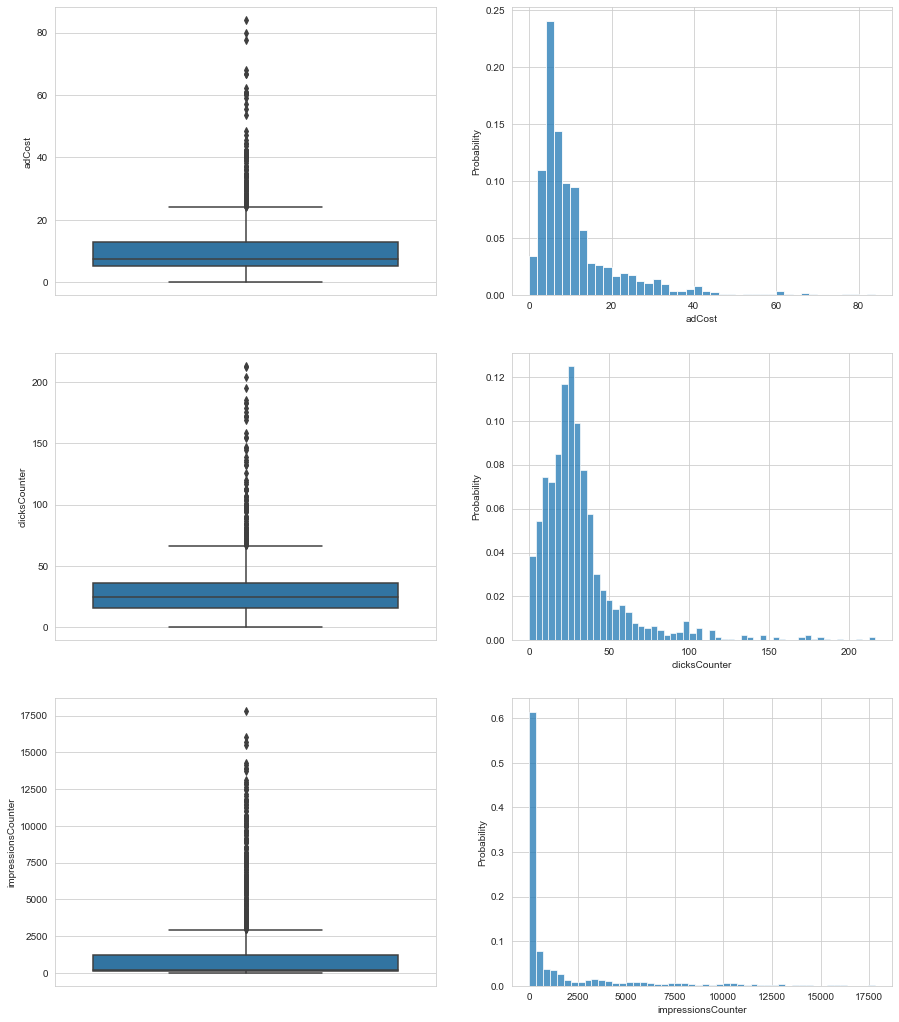

In [55]:
columns = ['adCost','clicksCounter','impressionsCounter']
percentile_list = [1,25,50,75.90,99]

cf.print_box_histplot(df, columns, percentile_list)

Tutti i KPI hanno distribuzioni right skewed, pertanto decido di rimpiazzare i  valori null con il 50 percentile della corrispondente campagna 

In [56]:
df_missing = cf.add_missing_combinations(df, date_column='calDate', columns=['connectionStream','campaignId'])
#tmp['calDate']= pd.to_datetime(df['calDate']).dt.date

CREO UN DIZIONARIO CON TUTTI I 50 PERCENTILI DI TUTTE LE CAMPAGNE PER CIASCUN KPI

Per ciascuna colonna applico quindi il dizionario sopra

In [60]:
columns = ['adCost','clicksCounter','impressionsCounter']
d = cf.create_median_dict(df, columns)
for col in columns:
    df_missing[col] = df_missing['campaignId'].map(d[col])
                                                           
df_missing.head(50)

,calDate,connectionStream,campaignId,adCost,clicksCounter,impressionsCounter
0,2021-08-25,4580834090943463925.google_ads,-8587735845139407532,10.58,17.5,670.0
1,2021-08-25,4580834090943463925.google_ads,-6046553957937071741,14.09,57.0,7709.0
2,2021-08-25,4580834090943463925.google_ads,-247250641193721630,10.43,12.0,208.0
3,2021-08-25,4580834090943463925.google_ads,1886376307672751723,5.93,27.0,89.0
4,2021-08-25,4580834090943463925.google_ads,3569910158619531168,10.69,24.0,5712.0
5,2021-08-25,4580834090943463925.google_ads,6045900822755737895,10.41,19.5,238.5


Concateno i due Dataframe e controllo che non ci siano date mancanti

PROVO IN PRIMA BATTUTA A CREARE UN DATASET CONTENENTE: Data, Costo, Click, Impression

In [19]:
df = df.groupby('calDate')[KPI_LIST].sum().reset_index()
df.to_csv(OUTPUT_FILE, index=False)

,calDate,adCost,clicksCounter,impressionsCounter
0,2021-08-02,28.45,23.0,184.0
1,2021-08-03,29.95,28.0,420.0
2,2021-08-04,54.85,50.0,3429.0
3,2021-08-05,125.73,127.0,10184.0
4,2021-08-06,96.65,101.0,9051.0


In [ ]:
#for conn in df['connectionStream'].unique():
#    data_plot = df[df['connectionStream'] == conn]
#    fig, ax = plt.subplots(1, 1, figsize=(17, 7))
#    sns.boxplot(x='campaignId', y='adCost', data=data_plot, ax=ax).set_title(conn)
#    fig.axes[0].tick_params(axis='x', labelrotation=60)
#    fig.show()